In [1]:
import glob
import pandas as pd
import numpy as np
import environment2
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import defaultdict
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
import statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
env = environment2.environment2()
user_list_2D = env.user_list_2D

In [3]:
user_list_2D[0]

'data/NDSI-2D/U_1.csv'

In [4]:
fileNames2D=user_list_2D

In [5]:
fileNames2D

array(['data/NDSI-2D/U_1.csv', 'data/NDSI-2D/U_10.csv',
       'data/NDSI-2D/U_11.csv', 'data/NDSI-2D/U_12.csv',
       'data/NDSI-2D/U_13.csv', 'data/NDSI-2D/U_14.csv',
       'data/NDSI-2D/U_15.csv', 'data/NDSI-2D/U_16.csv',
       'data/NDSI-2D/U_17.csv', 'data/NDSI-2D/U_18.csv',
       'data/NDSI-2D/U_19.csv', 'data/NDSI-2D/U_2.csv',
       'data/NDSI-2D/U_20.csv', 'data/NDSI-2D/U_3.csv',
       'data/NDSI-2D/U_4.csv', 'data/NDSI-2D/U_5.csv',
       'data/NDSI-2D/U_6.csv', 'data/NDSI-2D/U_7.csv',
       'data/NDSI-2D/U_8.csv', 'data/NDSI-2D/U_9.csv'], dtype='<U21')

In [6]:
def get_ROISubset(data):
    roi_subset=[]
    subset=1
    for i in range(len(data)):
        if data['State'][i]=='Sensemaking':
            if (i < (len(data) - 1)) and data['State'][i+1]!= 'Sensemaking':
                roi_subset.append(subset)
                subset=subset+1
            else:
                roi_subset.append(subset)
        else:
            roi_subset.append(subset)
    return roi_subset



In [311]:
# from collections import defaultdict
# def get_probabilities(dataframe):
#     dataframe['high-level-action']=np.zeros(len(dataframe),str)
#     probabilities=[]
#     map=dict()
#     # print(dataframe.head(5))
#     states=['Sensemaking','Foraging','Navigation']
#     actions=['change','same']
#     for state in states:
#       for action in actions:
#         map[state+action]=0
#
#
#     current_state=dataframe['State'][0]
#     for i in range(1,len(dataframe)):
#       if dataframe["State"][i]=='Answering':
#         dataframe["State"][i]='Sensemaking'
#       if dataframe["State"][i]== current_state:
#         dataframe["high-level-action"][i-1]="same"
#       else:
#         dataframe["high-level-action"][i-1]="change"
#       current_state=dataframe["State"][i]
#     dataframe["high-level-action"][len(dataframe)-1]="same"
#
#     for i in range(len(dataframe)):
#       if dataframe['State'][i]=="Navigation":
#         map[str(dataframe['State'][i]+dataframe['high-level-action'][i])] += 1
#         probs = (map['Navigationsame'])/(map['Navigationchange']  + map['Navigationsame'])
#
#       elif dataframe['State'][i]=="Foraging":
#         map[str(dataframe['State'][i]+dataframe['high-level-action'][i])] += 1
#         probs = (map['Foragingsame'])/(map['Foragingchange'] + map['Foragingsame'])
#
#       else:
#         map[str(dataframe['State'][i]+dataframe['high-level-action'][i])] += 1
#         probs = (map['Sensemakingsame'])/(map['Sensemakingchange'] + map['Sensemakingsame'])
#       probabilities.append(probs)
#     dataframe['probabilities']=probabilities
#     # return dataframe, map

In [312]:
from collections import defaultdict
def get_probabilities(dataframe):
    dataframe['high-level-action']=np.zeros(len(dataframe),str)
    probabilities=[]
    map=dict()
    # print(dataframe.head(5))
    states=['Sensemaking','Foraging','Navigation']
    for state in states:
        map[state]=0


    current_state=dataframe['State'][0]
    for i in range(1,len(dataframe)):
      if dataframe["State"][i]=='Answering':
        dataframe["State"][i]='Sensemaking'
      if dataframe["State"][i]== current_state:
        dataframe["high-level-action"][i-1]="same"
      else:
        dataframe["high-level-action"][i-1]="change"
      current_state=dataframe["State"][i]
    dataframe["high-level-action"][len(dataframe)-1]="same"

    for i in range(len(dataframe)):
      map[dataframe['State'][i]] += 1
      probs = (map['Foraging'])/(map['Sensemaking']  + map['Foraging']+map['Navigation'])
      probabilities.append(probs)
    dataframe['probabilities']=probabilities
    return dataframe, map

In [315]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        self.trend= None
    def Mann_Whitney_U_Test(self,timeseries_X,timeseries_Y):
        #check normality
        # result1 =shapiro(timeseries_X)
        # result2 =shapiro(timeseries_Y)
        # px=result1.pvalue
        # py=result2.pvalue

        # if px < self.SignificanceLevel and py < self.SignificanceLevel:
        #     print("X Y not normal",px,py)
        # else:
        #     print("Normal",px,py)
        #return ttest_ind(timeseries_X, timeseries_Y)

        return mannwhitneyu(timeseries_X, timeseries_Y,alternative='two-sided')

    def Wilcoxon_Test(self,timeseries_X, timeseries_Y):

        return wilcoxon(timeseries_X, timeseries_Y)

    def kpss_test(self, timeseries):
        kpsstest = kpss(timeseries, regression="ct", nlags="auto")
        kpss_output = pd.Series(
            kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
        )
        for key, value in kpsstest[3].items():
            kpss_output["Critical Value (%s)" % key] = value
        return kpss_output

    def adf_test(self,timeseries):
        dftest = adfuller(timeseries, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        return dfoutput


/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/2933231306.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="ct", nlags="auto")
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/2933231306.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="ct", nlags="auto")
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/2933231306.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="ct", nlags="auto")
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/29

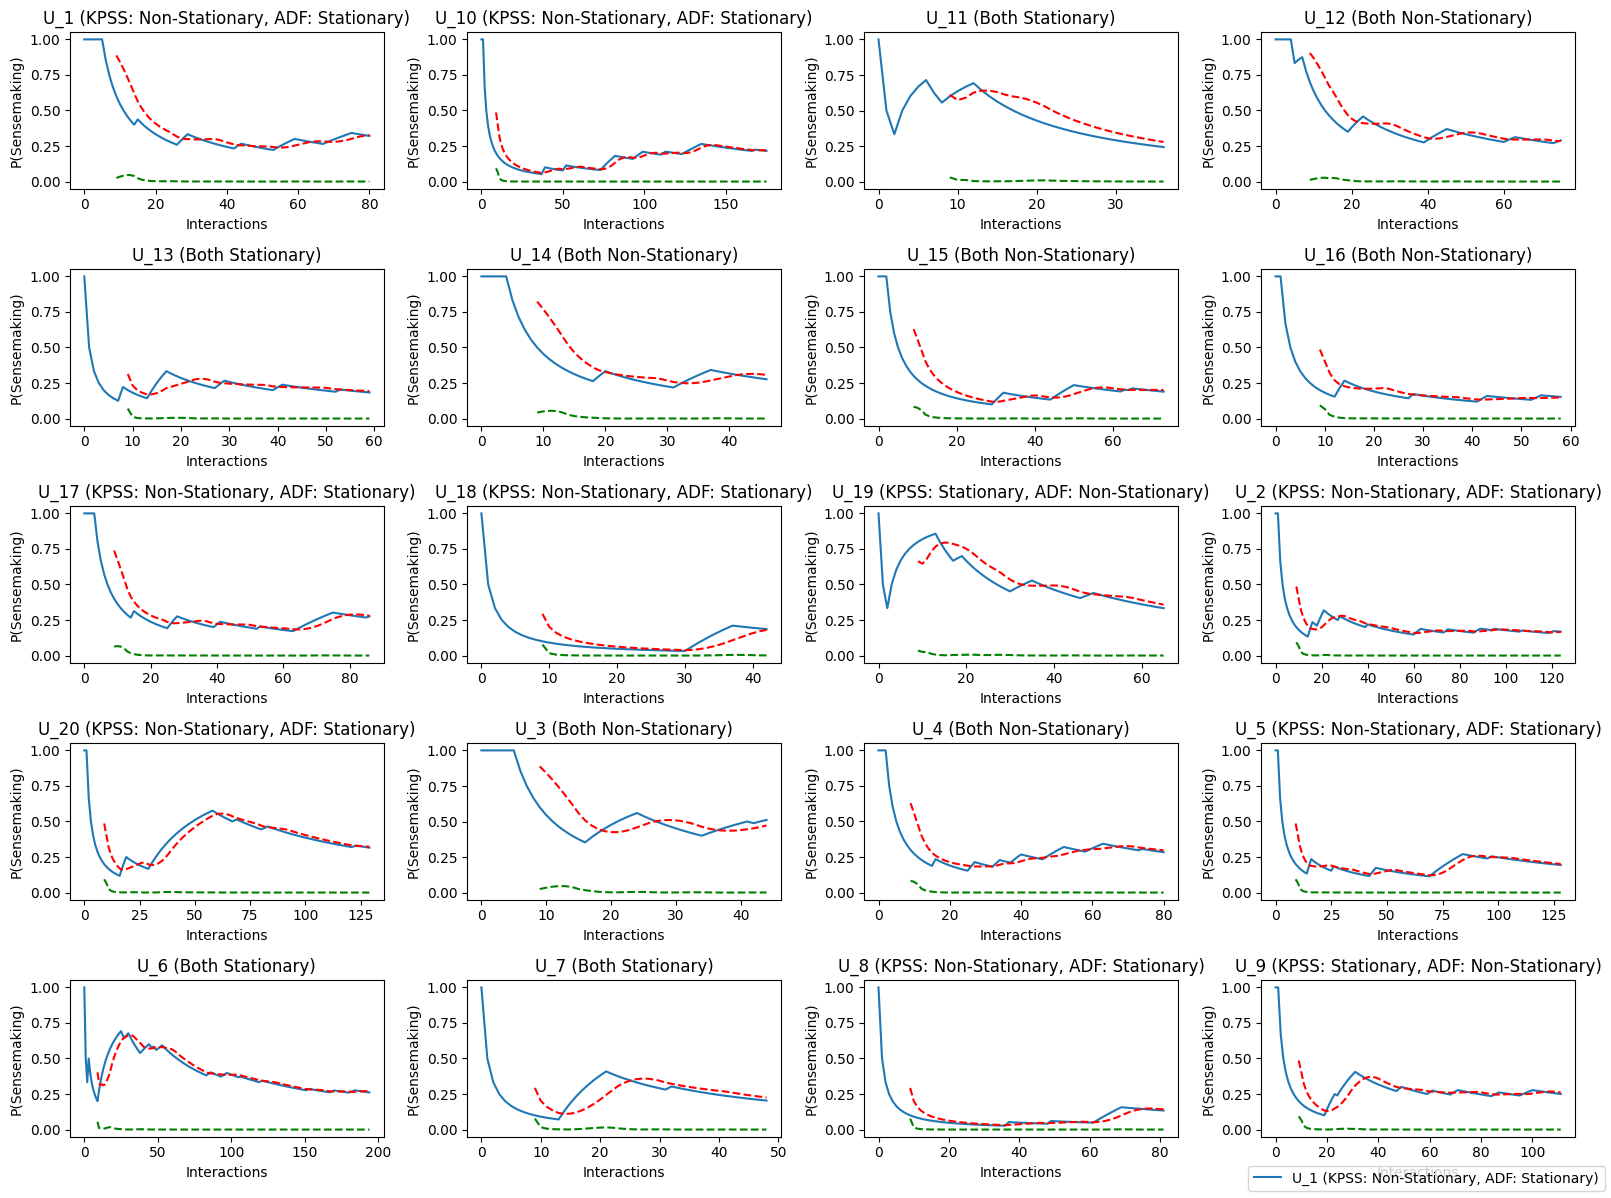

In [316]:
import matplotlib.pyplot as plt
def generate_legend_label(u, p_value_kpss, p_value_adf):
    # Generate a legend label with meaningful information
    if p_value_kpss > 0.05 and p_value_adf > 0.05:
        label = f"{u} (Both Stationary)"
    elif p_value_kpss > 0.05 and p_value_adf < 0.05:
        label = f"{u} (KPSS: Stationary, ADF: Non-Stationary)"
    elif p_value_kpss < 0.05 and p_value_adf > 0.05:
        label = f"{u} (KPSS: Non-Stationary, ADF: Stationary)"
    else:
        label = f"{u} (Both Non-Stationary)"
    return label


def plotter(df_probab, u, p_value_kpss, p_value_adf, ax):
    x = range(len(df_probab['probabilities']))
    y = list(df_probab['probabilities'])

    # Calculate rolling mean and rolling variance
    window_size = 10 # Adjust the window size as needed
    rolling_mean = df_probab['probabilities'].rolling(window=window_size).mean()
    rolling_var = df_probab['probabilities'].rolling(window=window_size).var()
    label=generate_legend_label(u, p_value_kpss, p_value_adf)
    # Plot the original data
    ax.plot(x, y, label=label)

    # Plot the rolling mean
    ax.plot(x, rolling_mean, color='red', linestyle='--')

    # Plot the rolling variance
    ax.plot(x, rolling_var, color='green', linestyle='--')

    ax.set_title(label)
    ax.set_xlabel("Interactions")
    ax.set_ylabel("P(Sensemaking)")

# Example usage
# Assuming df_probab contains your data, and you are iterating through 'fileNames2D'
fig, axs = plt.subplots(5, 4, figsize=(16, 12))

for i, u in enumerate(fileNames2D):
    df = pd.read_csv(u)
    u = u.lstrip('data/NDSI-2D\\')
    u = u.rstrip('.csv')
    df_probab, _ = get_probabilities(df)

    # Determine the subplot coordinates
    row, col = i // 4, i % 4

    sTest_state = StationarityTests()
    trend_kpss = sTest_state.kpss_test(df_probab['probabilities'])
    trend_adf = sTest_state.adf_test(df_probab['probabilities'])

    plotter(df_probab, u, trend_kpss['p-value'], trend_adf['p-value'], axs[row, col])

# Add a single global legend outside the subplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# Adjust layout
plt.tight_layout()
plt.show()


In [317]:
for u in fileNames2D:
      df = pd.read_csv(u)
      u=u.lstrip('data/NDSI-2D\\')
      u=u.rstrip('.csv')
      print("###########################",u)
      df_probab,_=get_probabilities(df)
      sTest_state = StationarityTests()
      trend_kpss=sTest_state.kpss_test(df_probab['probabilities'])
      print("KPSS Non-stationary", trend_kpss['p-value']<0.05)
      # trend_adf=sTest_state.adf_test(df_probab['probabilities'])
      # print("ADF Non-stationary", trend_adf['p-value']>.05)

########################### U_1
KPSS Non-stationary True
########################### U_10
KPSS Non-stationary True
########################### U_11
KPSS Non-stationary False
########################### U_12
KPSS Non-stationary True
########################### U_13
KPSS Non-stationary False
########################### U_14
KPSS Non-stationary True
########################### U_15
KPSS Non-stationary True
########################### U_16
KPSS Non-stationary True
########################### U_17
KPSS Non-stationary True
########################### U_18
KPSS Non-stationary True
########################### U_19
KPSS Non-stationary False
########################### U_2
KPSS Non-stationary True
########################### U_20
KPSS Non-stationary True
########################### U_3
KPSS Non-stationary True
########################### U_4
KPSS Non-stationary True
########################### U_5
KPSS Non-stationary True
########################### U_6
KPSS Non-stationary False
################

/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/2933231306.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="ct", nlags="auto")
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/2933231306.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="ct", nlags="auto")
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/2933231306.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="ct", nlags="auto")
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_42371/29

In [ ]:
user=[]
subtask=[]
all_states=[]
result=[]

output_dataframe=pd.DataFrame(columns=['User','Subtask','State','Result'])
for u in fileNames2D:
  print("###########################",u)
  index=[]

  all_dfs=[]
  maps=[]
  df = pd.read_csv(u)
  u=u.lstrip('data/NDSI-2D\\')
  #u=u.lstrip('data/NDSI-3D\\taskname_ndsi-3d-task_')
  u=u.rstrip('.csv')



  states=["Sensemaking",'Foraging','Navigation']
  mid= round(len(df)/2)

  # print(df.ROI_Cycle.unique())
  slice1=df[:mid].reset_index(drop=True)
  slice2=df[mid:].reset_index(drop=True)
  df1,_=get_probabilities(slice1)
  df2,_=get_probabilities(slice2)
  #print("Subset sizes:, ",len(df1),len(df2))
    #print("Roi Cycle: #######################", k, " TimeSpent: ############## ", dfs['IdleTime'].sum())
  dfs=[df1,df2]
  serieses=np.empty(shape=(2,3),dtype=object)
  for i in range(len(dfs)):
      for j in range(len(states)):
          same_probs=[]
          state_df=dfs[i].loc[(dfs[i]['State'] == states[j])]
          state_df.reset_index(inplace=True)
          for indx in range(len(state_df)):
              if state_df['high-level-action'][indx]=='same':
                  same_probs.append(state_df['probabilities'][indx])
              else:
                  same_probs.append(1-state_df['probabilities'][indx])

          serieses[i][j]=same_probs

  for k in range(serieses.shape[1]):
      all_states.append(states[k])
      user.append(u)
      subtask.append([1,2])
      x=list(serieses[0][k])
      y=list(serieses[1][k])
      print("Initial Length: ",len(x),len(y))

      if x is None:
        x = [0.5] * len(y)
      elif y is None:
        y = [0.5]* len(x)
      else:
          print(" ")
      # if len(x) > len(y):
      #   y = y + statistics.median(y) * (len(x) - len(y))
      # else:
      #   x = x + statistics.median(y) * (len(y) - len(x))


      if  (len(x)>2 and len(y)>2):
                sTest_state = StationarityTests()
                trend=sTest_state.Mann_Whitney_U_Test(x, y)
                print("State is: ", states[k], "  MWUT Result Non-Stationarity:  ", trend.pvalue < 0.05, trend.pvalue)
                result.append(trend.pvalue)
      else :
                 print("State is: ", states[k], "  MWUT Result is:  ","Not Enough Data")
                 result.append('NED')

output_dataframe['User']=user
output_dataframe['Result']=result
output_dataframe['State']=all_states
output_dataframe['Subtask']=subtask


In [ ]:
output_dataframe.head(5)

In [ ]:
output_dataframe.to_csv("data/NDSI-2D\\manwhitneyresults.csv", index=False)
#output_dataframe.to_csv("data/NDSI-3D\\probability_distribution_roi_cycle_3d.csv", index=False)

In [ ]:
from scipy import stats
filtered_dataframe = output_dataframe[output_dataframe['Result'] != 'NED']
nonNEDdataframe=filtered_dataframe.copy()

In [ ]:
a=stats.false_discovery_control(list(filtered_dataframe['Result']),method='by')

In [ ]:
filtered_dataframe['Result']=a

In [ ]:
len(filtered_dataframe)

In [ ]:
stats.false_discovery_control([0.2,0.00004,0.2,0.3])

In [ ]:
len(output_dataframe)

In [ ]:
filtered_dataframe.to_csv("data/NDSI-2D/adjusted_manwhitneyresults.csv", index=False)

In [ ]:
a

In [ ]:
nonNEDdataframe['Result']

In [ ]:
output_dataframe['Result']

In [ ]:
import matplotlib.pyplot as plt

plt.plot(nonNEDdataframe['Result'], label='nonNEDdataframe')
plt.plot(filtered_dataframe['Result'], label='filtered_dataframe')

plt.xlabel('Index')
plt.ylabel('Result Values')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for nonNEDdataframe
plt.hist(nonNEDdataframe['Result'], bins=20, alpha=0.5, label='original_hypothesis')

# Plot histogram for filtered_dataframe
plt.hist(filtered_dataframe['Result'], bins=20, alpha=0.5, label='multiple_hypothesis_corrected')

plt.xlabel('Result Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
x,y,z,w=multipletests(list(filtered_dataframe['Result']), alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)


In [ ]:
x

In [ ]:
x